### 10-1. 프로젝트: 한국어 데이터로 챗봇 만들기

In [2]:
# 필요 패키지
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1. 데이터 수집하기


In [3]:
import pandas as pd
# 데이터를 읽어봅시다.
data = pd.read_table('~/aiffel/Untitled Folder/ChatbotData.csv')
# test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/sentiment_classification/data/ratings_test.txt')
data_path = '~/aiffel/Untitled Folder/ChatbotData.csv'
print(data.head())
print(data.info)

                       Q,A,label
0            12시 땡!,하루가 또 가네요.,0
1        1지망 학교 떨어졌어,위로해 드립니다.,0
2     3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3  3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4           PPL 심하네,눈살이 찌푸려지죠.,0
<bound method DataFrame.info of                                                Q,A,label
0                                    12시 땡!,하루가 또 가네요.,0
1                                1지망 학교 떨어졌어,위로해 드립니다.,0
2                             3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3                          3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4                                   PPL 심하네,눈살이 찌푸려지죠.,0
...                                                  ...
11818                훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819                     훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820                               흑기사 해주는 짝남.,설렜겠어요.,2
11821  힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아...
11822                    힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2

[11823 rows x 1 columns]>


### Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.
<참조PR> :


In [4]:
import re

# 사용할 샘플의 최대 개수
MAX_SAMPLES = 11823

# 한글 데이터에 맞는 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence의 양쪽 공백을 제거
    sentence = sentence.strip()

    # 특수 문자를 분리하고, 필요 없는 문자는 공백으로 대체
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 앞뒤로 공백 추가
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)  # 한글, 영문, 숫자, 구두점 제외한 문자 제거 #! 핵심!
    sentence = re.sub(r'[" "]+', " ", sentence)  # 다중 공백을 단일 공백으로 치환

    """
	•	r" \1 ":
	•	\1은 ()로 캡처된 패턴을 참조.
	•	예: 구두점 .이 캡처되었다면, \1은 .으로 변환.
    
	•	[^...]: 대괄호 안에 포함되지 않은 문자들을 매칭.
	•	가-힣: 한글 범위 (자음, 모음 포함).
	•	a-zA-Z: 영어 소문자 및 대문자.
	•	0-9: 숫자.
	•	?.!,: 구두점.
	•	+: 앞의 패턴이 1번 이상 반복되는 경우 매칭.
    
	•	정규식 패턴:
	•	[" "]: 공백 문자를 매칭.
	•	+: 앞의 패턴이 1번 이상 반복되는 경우 매칭.
    
    
    """
    
    # 최종 양쪽 공백 제거
    sentence = sentence.strip()

    return sentence

# 데이터 로드 및 전처리 함수
def load_conversations_from_csv(file_path):
    # CSV 파일 읽기
    data = pd.read_csv(file_path, header=None)

    # 질문과 답변 분리 및 전처리 적용
    questions = data[0].apply(preprocess_sentence).tolist()
    answers = data[1].apply(preprocess_sentence).tolist()

    # 샘플 개수 제한
    questions = questions[:MAX_SAMPLES]
    answers = answers[:MAX_SAMPLES]

    return questions, answers

In [5]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
questions, answers = load_conversations_from_csv(data_path)
# 결과 확인
print("샘플 질문:", questions[:5])
print("샘플 답변:", answers[:5])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

샘플 질문: ['Q', '12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다']
샘플 답변: ['A', '하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .']
전체 샘플 수 : 11823
전체 샘플 수 : 11823


- 데이터 셋을 살펴보면, 한글 단어만 있는 것이 아닌 영단어도 섞여 있음을 고려해야 했습니다.

In [6]:
max_length = max(len(q) for q in questions)
print("샘플 중 가장 긴 질문의 길이:", max_length)

# 질문 길이의 평균 계산
average_length = sum(len(q) for q in questions) / len(questions)
print("질문의 평균 길이:", average_length)

샘플 중 가장 긴 질문의 길이: 57
질문의 평균 길이: 13.212974710310412


- Max_Length를 고려하여 , 각 샘플 길이의 평균과 max를 구했습니다.

### Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용  

1. 단어장(Vocabulary) 만들기   
우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어보겠습니다. 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듭니다.






In [7]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


이때 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해 줍니다. 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 되겠죠?

In [8]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8161]
END_TOKEN의 번호 : [8162]
8163


2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면,   
tokenizer.encode()로 각 단어를 정수로 변환할 수 있고  
 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.





In [9]:
# # 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행. 각 토큰을 고유한 정수로 변환. 예시
# print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
# print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

In [10]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print("max_length : ",MAX_LENGTH)

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

max_length :  40


- 평균과, max길이를 볼때 40으로 정하여도 학습에 큰 영향은 없을것이라 생각하였습니다. (추후 max_length 증가시켜서 비교해보기)

In [11]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8163
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


3. 교사 강요 수행   
질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.  

Seq2Seq 모델은 입력 시퀀스를 받아 출력 시퀀스를 생성합니다. 예를 들어, 번역 모델은 문장을 입력받아 번역된 문장을 출력합니다. 출력 시퀀스의 각 단어는 이전까지의 출력 단어들에 영향을 받습니다.  
• <훈련 과정>:  
• 모델은 순차적으로 출력 시퀀스의 각 단어를 생성합니다.  
• 모델의 출력은 이전에 생성된 단어를 기반으로 다음 단어를 예측합니다.  
• <문제점>:  
• 모델이 훈련 초기에 잘못된 단어를 생성하면, 잘못된 단어가 다음 입력으로 사용되어 오류가 누적됩니다.  
• 이로 인해 모델이 원하는 대로 학습되지 않을 수 있습니다.   
• 교사 강요의 해결책:  
• 모델이 훈련 중에 이전 단계의 예측값 대신 실제 정답(레이블)을 다음 입력으로   사용하여 훈련의 안정성을 높입니다.  

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions, # 모델의 인코더에 전달할 입력 시퀀스.
        'dec_inputs': answers[:, :-1] # •	answers[:, :-1]: 정답 시퀀스에서 마지막 토큰을 제거한 데이터.
	                                    # •	이유: 디코더는 이전 출력 단어를 다음 입력으로 사용하므로 마지막 단어는 필요 없음.
    },
    {
        'outputs': answers[:, 1:] # answers[:, 1:]: 정답 시퀀스에서 첫 번째 토큰을 제거한 데이터.
	                                # •	이유: 디코더 출력은 입력보다 한 단계 앞서야 함.
    },
))

dataset = dataset.cache() # 데이터셋을 캐시(메모리에 저장)하여 데이터 로딩 속도를 향상.
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # 데이터 로딩과 모델 훈련을 병렬로 처리하여 학습 속도를 최적화.

# 예제 데이터로 모델 출력 확인
example_inputs = questions[:2]  # 첫 두 샘플
example_dec_inputs = answers[:2, :-1]  # 첫 두 샘플의 디코더 입력

# # 예제 데이터로 모델 출력 확인
# example_inputs = questions[:2]  # 첫 두 샘플
# example_dec_inputs = answers[:2, :-1]  # 첫 두 샘플의 디코더 입력

# # 모델 호출
# outputs = model([example_inputs, example_dec_inputs])
# print("Model output shape:", outputs.shape)


### Step 4. 모델 구성하기
트랜스포머 모델을 구현

### -1. 포지셔널 인코딩 레이어

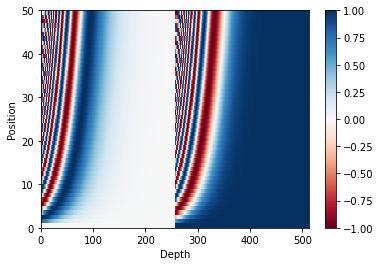

In [13]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        # 클래스 초기화에 사용된 매개변수를 반환
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "position": self.position,
            "d_model": self.d_model,
        })
        return config

# 행의 크기가 50, 열의 크기가 512인 행렬을 그려봅시다. 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것입니다.

# 50x512 크기의 포지셔널 인코딩 생성
sample_pos_encoding = PositionalEncoding(position=50, d_model=512)

# Positional Encoding 시각화
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### -2. 스케일 닷 프로덕트 어텐션

In [14]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


### -3. 멀티헤드 어텐션

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention", **kwargs):
        super(MultiHeadAttention, self).__init__(name=name, **kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어 떨어져야 함
        assert self.d_model % self.num_heads == 0, "d_model must be divisible by num_heads"

        # 각 헤드의 차원
        self.depth = self.d_model // self.num_heads

        # Dense layers for Q, K, V
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # 최종 출력 Dense layer
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        """입력을 여러 헤드로 분리"""
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        """
        스케일드 닷 프로덕트 어텐션을 통해 입력 데이터를 처리
        Args:
          inputs: {'query': Q, 'key': K, 'value': V, 'mask': 마스크}
        """
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs.get('mask', None)
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 여러 헤드로 분리
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        # 헤드를 다시 연결
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 Dense layer 적용
        outputs = self.dense(concat_attention)
        return outputs

    def get_config(self):
        """클래스 초기화에 사용된 매개변수를 반환"""
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
        })
        return config

In [16]:
# class MultiHeadAttention(tf.keras.layers.Layer):
    
#     def __init__(self, d_model, num_heads, name="multi_head_attention", **kwargs):
#         super(MultiHeadAttention, self).__init__(name=name, **kwargs)
#         self.num_heads = num_heads
#         self.d_model = d_model

#     assert d_model % self.num_heads == 0

#     self.depth = d_model // self.num_heads

#     self.query_dense = tf.keras.layers.Dense(units=d_model)
#     self.key_dense = tf.keras.layers.Dense(units=d_model)
#     self.value_dense = tf.keras.layers.Dense(units=d_model)

#     self.dense = tf.keras.layers.Dense(units=d_model)
    
#     def split_heads(self, inputs, batch_size):
#         inputs = tf.reshape(
#             inputs, shape=(batch_size, -1, self.num_heads, self.depth))
#         return tf.transpose(inputs, perm=[0, 2, 1, 3])

#     def call(self, inputs):
#         query, key, value, mask = inputs['query'], inputs['key'], inputs[
#             'value'], inputs['mask']
#         batch_size = tf.shape(query)[0]

#     # Q, K, V에 각각 Dense를 적용합니다
#         query = self.query_dense(query)
#         key = self.key_dense(key)
#         value = self.value_dense(value)

#     # 병렬 연산을 위한 머리를 여러 개 만듭니다
#         query = self.split_heads(query, batch_size)
#         key = self.split_heads(key, batch_size)
#         value = self.split_heads(value, batch_size)

#     # 스케일드 닷 프로덕트 어텐션 함수
#         scaled_attention = scaled_dot_product_attention(query, key, value, mask)

#         scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

#     # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
#         concat_attention = tf.reshape(scaled_attention,
#                                   (batch_size, -1, self.d_model))

#     # 최종 결과에도 Dense를 한 번 더 적용합니다
#         outputs = self.dense(concat_attention)

#         return outputs

#         def get_config(self):
#             config = super(MultiHeadAttention, self).get_config()
#             config.update({
#                 "d_model": self.d_model,
#                 "num_heads": self.num_heads,
#             })
#             return config
# print("슝=3")

### -4. 마스킹(패딩, 룩어헤드)

In [17]:
# 패딩 마스킹
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

슝=3
tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [18]:
# 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
def create_look_ahead_mask(x): # x는 시퀀스 데이터로, 일반적으로 배치(batch)와 시퀀스 길이(sequence length)를 포함하는 텐서입니다. (예: [batch_size, seq_len])
  seq_len = tf.shape(x)[1] # 입력 텐서 x의 **시퀀스 길이(seq_len)**를 계산.
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  """ 시퀀스 길이(seq_len)에 따라 (seq_len, seq_len) 크기의 1로 채워진 텐서를 생성.
	2.	tf.linalg.band_part(..., -1, 0):
	•	입력 행렬의 상삼각 행렬(Upper Triangular)을 추출합니다.
	•	-1: 행(row) 방향으로 제한 없음.
	•	0: 열(column) 방향으로 하한 설정.
  [[1., 0., 0., 0.],
  [1., 1., 0., 0.],
  [1., 1., 1., 0.],
  [1., 1., 1., 1.]]
	3.	1 - ...:
	•	Look-Ahead Mask를 생성하기 위해 상삼각 행렬을 반전. (1은 마스킹됨, 0은 허용됨)
	•	상삼각 행렬을 반전하여 Look-Ahead Mask를 생성합니다.
	•	1은 미래 시점(차단), 0은 현재 및 과거 시점(허용)을 나타냅니다.
  [[0., 1., 1., 1.],
  [0., 0., 1., 1.],
  [0., 0., 0., 1.],
  [0., 0., 0., 0.]]
  """
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
  """ 	•	tf.maximum: 요소별로 두 텐서 중 더 큰 값을 선택합니다.
	•	Look-Ahead Mask와 Padding Mask를 결합합니다.
	•	두 마스크가 동시에 적용됩니다:
	•	Look-Ahead Mask는 미래 시점을 차단.
	•	Padding Mask는 패딩 값을 무시."""
  """ 예시
  	•	x = [[1, 2, 0, 0]]일 경우:
	•	Look-Ahead Mask:
[[0., 1., 1., 1.],
 [0., 0., 1., 1.],
 [0., 0., 0., 1.],
 [0., 0., 0., 0.]]

	•	Padding Mask:
[[0., 0., 1., 1.],
 [0., 0., 1., 1.],
 [0., 0., 1., 1.],
 [0., 0., 1., 1.]]

	•	결합된 최종 마스크:
[[0., 1., 1., 1.],
 [0., 0., 1., 1.],
 [0., 0., 1., 1.],
 [0., 0., 1., 1.]]
  """
print("슝=3")

print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))
"""[0, 5, 1, 5, 5] 예시
[[1., 1., 1., 1., 1.],
 [1., 0., 1., 1., 1.],
 [1., 0., 0., 1., 1.],
 [1., 0., 0., 0., 1.],
 [1., 0., 0., 0., 0.]]
두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력합니다.
#어텐션 연산 시에 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있겠죠?"""



슝=3
tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


'[0, 5, 1, 5, 5] 예시\n[[1., 1., 1., 1., 1.],\n [1., 0., 1., 1., 1.],\n [1., 0., 0., 1., 1.],\n [1., 0., 0., 0., 1.],\n [1., 0., 0., 0., 0.]]\n두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력합니다.\n#어텐션 연산 시에 패딩 마스킹을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있겠죠?'

### -5. 인코더

In [19]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  """	•	입력 인자:
	•	units: 두 번째 서브 레이어의 첫 번째 완전 연결층에서 사용될 유닛 수 (히든 레이어의 크기).
	•	d_model: 모델 차원. 입력과 출력의 크기가 동일하게 유지됨.
	•	num_heads: 멀티 헤드 어텐션에서 사용할 헤드(head)의 개수.
	•	dropout: 드롭아웃 비율.
	•	name: 레이어의 이름 (기본값: “encoder_layer”).
	•	출력:
	•	tf.keras.Model 객체를 반환."""

  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
  #	•	(batch_size, 1, 1, sequence_length) 형태.

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask #패딩 마스크(padding_mask)를 통해 패딩된 토큰의 영향을 제거.
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention) # 어텐션 결과에 드롭아웃을 적용해 과적합을 방지.
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention) # Residual Connection(잔차 연결): 입력(inputs)과 어텐션 결과(attention)를 더한 후 정규화
      # inputs + attention: 원래 입력과 어텐션 결과를 더해 정보 손실을 방지.

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  """	•	어텐션 결과에 ReLU 활성화를 적용한 완전 연결층.
	•	출력 크기: (batch_size, sequence_length, units)."""

  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


인코더 층을 쌓아 인코더 만들기  
이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용되었습니다. 위 그림에서는 Normalize라고 표시된 부분에 해당됩니다.

트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다. 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [20]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):

  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


### -6. 디코더

In [22]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs) # Residual Connection(잔차 연결): 원래 입력(inputs)과 어텐션 결과를 더함.



  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs, # Key, Value: 인코더 출력(enc_outputs).
          'value': enc_outputs,
          'mask': padding_mask # Padding Mask를 적용하여 인코더 출력에서 패딩된 토큰을 무시.
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)



  # 세 번째 서브 레이어 : 2개의 완전연결층 = 피드포워드 네트워크
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


디코더 층을 쌓아 디코더 만들기  
이렇게 구현한 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다.

인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓습니다. 논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.


In [23]:
# 디코더 층 쌓아 디코더 만들기
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### -7. 모델 정의 및 학습하기

In [24]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [52]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
#12.02 NUM LAYERS = 2
#12.03 NUM LAYERS = 6 비교 실험

D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3143936     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### -8. 손실함수  
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [53]:
@tf.function
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    y_pred = y_pred[:, :tf.shape(y_true)[1], :]  # y_true 길이에 맞추기

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

- 디버깅 : y_true : 출력 39 / y_pred 출력길이 40 으로 모델 훈련시 오류가 났었습니다.
- 그 이유는, 디코더 입력(dec_inputs)에 시작 토큰(START_TOKEN)을 추가하고, 타겟(outputs)에서 종료 토큰(END_TOKEN)을 제외했기 때문입니다. 즉 y_pred의 길이가 길게끔, 모델이 전체 시퀀스 길이(40)로 예측을 생성했기 때문입니다.
-   y_pred = y_pred[:, :tf.shape(y_true)[1], :]  # (None, 39, vocab_size)
 으로, start 토큰을 제외시켜줍니다.

### -9. 커스텀 된 학습률(Learning rate)
딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용

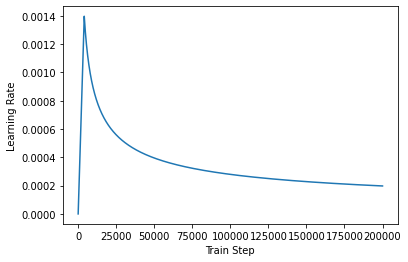

In [54]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        """
        학습률 스케줄을 정의합니다.

        Args:
            d_model (int): 모델 차원.
            warmup_steps (int): 워밍업 단계의 수.
        """
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        """
        학습률을 계산합니다.

        Args:
            step (int): 현재 학습 단계.

        Returns:
            tf.Tensor: 학습률.
        """
        # step을 float으로 변환
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        """
        직렬화를 위한 설정 반환.

        Returns:
            dict: 클래스 매개변수의 설정.
        """
        return {
            "d_model": self.d_model.numpy(),  # 텐서를 numpy 값으로 변환
            "warmup_steps": self.warmup_steps
        }

# 샘플 학습률 스케줄링 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

### -10. 모델 컴파일 및 훈련

- 데이터 셋 나누기 (loss 평가 위해)

In [55]:
# val_loss 구하기 위해, 데이터 셋 분리 (train, validation)
from sklearn.model_selection import train_test_split

# 데이터셋 분리 (80% 학습, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(
    questions, answers, test_size=0.2, random_state=42
)

from tensorflow.keras.preprocessing.sequence import pad_sequences

# 패딩 처리
X_train = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
X_val = pad_sequences(X_val, maxlen=MAX_LENGTH, padding='post')
y_train = pad_sequences(y_train, maxlen=MAX_LENGTH, padding='post')
y_val = pad_sequences(y_val, maxlen=MAX_LENGTH, padding='post')

# 학습 데이터셋
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': X_train,           # 입력 데이터
        'dec_inputs': y_train[:, :-1]  # 디코더 입력 (마지막 토큰 제외)
    },
    {
        'outputs': y_train[:, 1:]      # 디코더 출력 (첫 번째 토큰 제외)
    }
)).batch(BATCH_SIZE)

# 검증 데이터셋
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': X_val,            # 입력 데이터
        'dec_inputs': y_val[:, :-1]   # 디코더 입력 (마지막 토큰 제외)
    },
    {
        'outputs': y_val[:, 1:]       # 디코더 출력 (첫 번째 토큰 제외)
    }
)).batch(BATCH_SIZE)

In [56]:
# accuracy

from tensorflow.keras.callbacks import ModelCheckpoint
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

@tf.function
def accuracy(y_true, y_pred):
    # y_pred의 시퀀스 길이를 y_true에 맞춤
    y_pred = y_pred[:, :tf.shape(y_true)[1], :]  # y_true의 길이에 맞춤

    # y_pred에서 가장 높은 확률을 가진 인덱스 선택
    y_pred = tf.argmax(y_pred, axis=-1)  # (batch_size, sequence_length)

    # y_true와 y_pred를 동일한 데이터 타입으로 변환
    y_true = tf.cast(y_true, dtype=tf.int32)
    y_pred = tf.cast(y_pred, dtype=tf.int32)

    # y_true와 y_pred를 1차원으로 변환
    y_true = tf.reshape(y_true, shape=(-1,))
    y_pred = tf.reshape(y_pred, shape=(-1,))

    # y_true와 y_pred가 동일한지 비교
    matches = tf.cast(tf.equal(y_true, y_pred), tf.float32)

    # 정확도 계산
    return tf.reduce_mean(matches)

In [57]:
# 모델 체크포인트 디버깅 되지 않았을때, 훈련
# # 모델 컴파일
# model.compile(
#     optimizer=optimizer,
#     loss=loss_function,  # 수정된 손실 함수
#     metrics=[accuracy]   # 수정된 정확도 함수
# )

# # 모델 훈련
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=30,
#     verbose=1  # 진행 상황 표시
# )

- 디버깅 시작 model compile, fit 오류 -> loss함수 수정
- 훈련 1차시도 및 시각화

In [58]:
for data in train_dataset.take(1):
    print("Inputs shape:", data[0]['inputs'].shape)
    print("Decoder Inputs shape:", data[0]['dec_inputs'].shape)
    print("Outputs shape:", data[1]['outputs'].shape)

Inputs shape: (64, 40)
Decoder Inputs shape: (64, 39)
Outputs shape: (64, 39)


In [60]:
# def accuracy(y_true, y_pred):
#   y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
#   return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# 최적의 성능을 저장할 파일 경로
checkpoint_filepath = '~/aiffel/Untitled Folder/best_model_chatbot.keras'

# 콜백 정의
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,  # 모델 저장 경로
                                    monitor='val_loss',          # 검증 손실 기준으로 저장
                                    save_best_only=True,         # 최상의 모델만 저장
                                    verbose=1)


model.compile(
    optimizer=optimizer,
    loss=loss_function,  # 수정된 손실 함수
    metrics=[accuracy]   # 수정된 정확도 함수
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[model_checkpoint],
    verbose=1
)

from tensorflow.keras.models import load_model

# 사용자 정의 객체 추가
custom_objects = {
    'PositionalEncoding': PositionalEncoding,
    'MultiHeadAttention': MultiHeadAttention,
    'CustomSchedule': CustomSchedule,
    'loss_function': loss_function  # 사용자 정의 손실 함수 추가
}

# 저장된 모델 경로
checkpoint_filepath = '~/aiffel/Untitled Folder/best_model_chatbot.keras'

# 모델 로드
best_model1 = load_model(checkpoint_filepath, custom_objects=custom_objects)

print("모델이 성공적으로 로드되었습니다!")

Epoch 1/30
148/148 [==============================] - 16s 70ms/step - loss: 1.3135 - accuracy: 0.0478 - val_loss: 1.1930 - val_accuracy: 0.0496

Epoch 00001: val_loss improved from inf to 1.19298, saving model to ~/aiffel/Untitled Folder/best_model_chatbot.keras
Epoch 2/30
148/148 [==============================] - 9s 63ms/step - loss: 1.1086 - accuracy: 0.0495 - val_loss: 1.0423 - val_accuracy: 0.0502

Epoch 00002: val_loss improved from 1.19298 to 1.04232, saving model to ~/aiffel/Untitled Folder/best_model_chatbot.keras
Epoch 3/30
148/148 [==============================] - 9s 63ms/step - loss: 0.9938 - accuracy: 0.0507 - val_loss: 0.9696 - val_accuracy: 0.0528

Epoch 00003: val_loss improved from 1.04232 to 0.96956, saving model to ~/aiffel/Untitled Folder/best_model_chatbot.keras
Epoch 4/30
148/148 [==============================] - 9s 63ms/step - loss: 0.9323 - accuracy: 0.0538 - val_loss: 0.9296 - val_accuracy: 0.0550

Epoch 00004: val_loss improved from 0.96956 to 0.92958, savin

- 훈련 2차 시도 및 시각화
- 모델 체크포인트 디버깅 완료

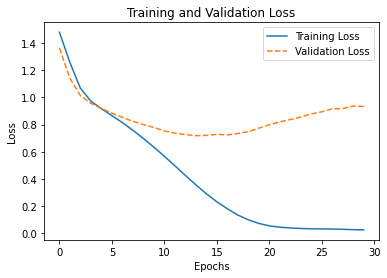

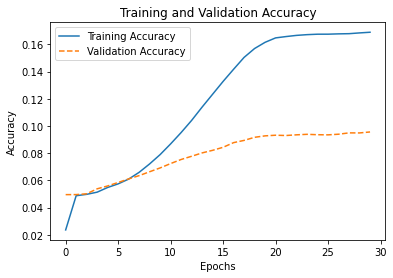

In [69]:
# 시각화 1차 (모델 체크포인트 디버깅을 못했을 때) - 최적의 모델 저장 못함
import matplotlib.pyplot as plt

# 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

- val loss 오퍼피팅을 확인 한 점이 위 챗봇 모델의 성능을 평가하는데 지표가 될 수 있을까?  /해결  
    -> val loss는 현재 모델이 어느정도 훈련이 되고있는지를 볼 수 있는 지표가 될 수 있습니다. 위 모델은 정답이 주어진 상황에서 학습을 하고 있기 때문입니다.  
    -> 하지만 하단의 질문처럼, 정확도는 위 모델의 평가지표로 사용될 수 없습니다. 생성된 텍스트 자체가 정답 문장과 완전히 일치하지 않더라도, 의미적 유사성 등을 고려하여 올바른 답변으로 판단될 수 있기 때문입니다.  
    
- 정확도가 위 챗봇을 평가하는 정확한 평가지표가 될 수 있을까? (공부) -> 퍼실님께 질문/해결
- 이전에 언급 된 평가지표 중 'BLEU', 'ROUGE', '정성적 평가'를 시도해 보려고 합니다. /완료

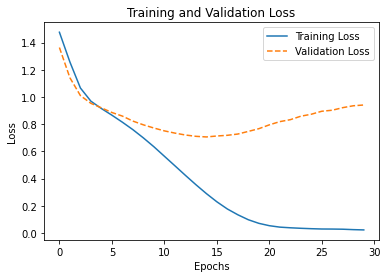

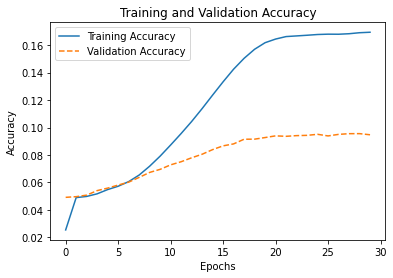

In [141]:
# 추가시도 콜백 지정 / 모델 체크포인트는 에러가 해결되지 않아 위 방법 시도
# 시각화 2차
import matplotlib.pyplot as plt

# 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

- 12.02 시각화 2차  Num layers=2, D-MODEL=256  
Epoch 00030: val_loss did not improve from 0.70745
모델이 성공적으로 로드되었습니다!

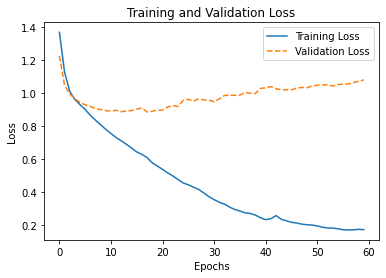

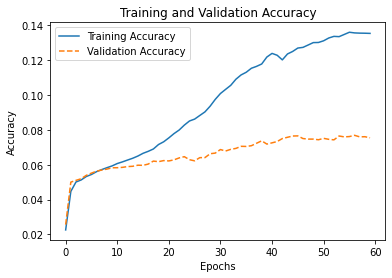

In [46]:
# 추가시도 콜백 지정 / 모델 체크포인트는 에러가 해결되지 않아 위 방법 시도
# 시각화 3차
import matplotlib.pyplot as plt

# 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

- 12.03 시각화 3차
- 12.02(모델과 비교_Num layers=6, D-MODEL=512로, 인코더 디코더 층의 개수 및 입출력 차원 증가
- Epoch 00060: val_loss did not improve from 0.88663
모델이 성공적으로 로드되었습니다!
- 모델의 복잡성 증가 -> 성능 저하가 보입니다. -> 모델을 경량화 했을때 오히려 훈련이 더 잘된 결과를 볼 수 있습니다.[시각화 2차 참조]   
    -> (확인, 논의 필요)
- 검증 손실이 낮은 모델이 반드시 더 좋은 문장을 생성한다고 보장할 수 없으므로, 추가적인 평가 지표(BLEU, ROUGE, METEOR 등)로 확인이 필요합니다.

### 퍼실님 코멘트
- 1차 2차 모델 모두 오버피팅이 확인된 상황입니다.
- 2차 모델의 성능이 더 낮은 이유는, 데이터셋의 크기가 모델에 비해 너무 작고 이는 학습성능에 영향을 미칠수 있다고 합니다.
- 따라서 크기가 작은 데이터셋에서는, 경량화된 모델이 더 성능이 좋을 수 있습니다.


### Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수 만들기

학습된 트랜스포머를 사용하여 테스트를 진행합니다.
예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.  


위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

In [70]:
def decoder_inference(sentence): # *디코더(Decoder)**를 사용해 문장을 입력받고, 해당 문장을 기반으로 모델이 예측한 결과를 출력하는 추론(Inference) 함수
  sentence = preprocess_sentence(sentence) # 입력 문장을 전처리하여 모델이 이해할 수 있는 형태로 변환. 소문자로 변환, 공백 정리, 불필요한 문자 제거 등.

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]] 8331,8332 시작 및 종료 토큰
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0) # 문장을 토크나이저(tokenizer)를 사용해 정수 시퀀스로 변환.

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0) # 모델 입력은 2D 텐서(배치 크기 포함)여야 하므로 차원을 확장. 결과 shape: (1, sequence_length).


  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = best_model1(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break


    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

In [71]:
def sentence_generation(sentence): # 이 함수는 decoder_inference를 호출해 디코더 추론을 수행하고, 모델이 예측한 정수 시퀀스를 텍스트 형태로 변환하여 출력합니다.
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence) # sentence: 사용자가 입력한 텍스트 문장.
 # 예상 반환값 정수 시퀀스: [8331, 86, 30, 5, 1059, 7, 8332] (예: 시작 토큰부터 종료 토큰까지의 단어 ID).

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


### -1. 정성적 평가
NUM_LAYERS = 2  
D_MODEL = 256

In [162]:
questions_test, answers_test = load_conversations_from_csv(data_path)
# 원질문, 원답변 30개
questions_sample = questions_test[1:31]
answers_sample = answers_test[1:31]

# sentence_generation 함수 결과 생성
generated_sentences = [sentence_generation(q) for q in questions_sample[0:30]]

# 데이터프레임 생성
df_test_results = pd.DataFrame({
    'Questions (원문 질문)': questions_sample[0:30],  # 1열: 원문 질문
    'Answers (원문 답변)': answers_sample[0:30],      # 2열: 원문 답변
    'Generated Sentence (생성된 문장)': generated_sentences  # 3열: 생성된 문장
})

df_test_results.index = range(1, len(df_test_results) + 1)
df_test_results

입력 : 12시 땡 !
출력 : 포맷해보세요 .
입력 : 1지망 학교 떨어졌어
출력 : 미리 충전해주세요 .
입력 : 3박4일 놀러가고 싶다
출력 : 그런 날이 있더라고요 .
입력 : 3박4일 정도 놀러가고 싶다
출력 : 그런 날이 있더라고요 .
입력 : PPL 심하네
출력 : 그분 생각을 많이 했나 봐요 . 곧 좋은 소식이 들리려고 하는 것 아닐까요 ?
입력 : SD카드 망가졌어
출력 : 다시 새로 사는 게 마음 편해요 .
입력 : SD카드 안돼
출력 : 다시 새로 사는 게 마음 편해요 .
입력 : SNS 맞팔 왜 안하지
출력 : SNS 흔적이 되지 않겠지만 힘내세요 .
입력 : SNS 시간낭비인 거 아는데 매일 하는 중
출력 : 시간을 좀 쉬었다고 가세요 .
입력 : SNS 시간낭비인데 자꾸 보게됨
출력 : 시간을 정해보세요 .
입력 : SNS보면 나만 빼고 다 행복해보여
출력 : 그래도 후회는 후회를 낳을뿐이에요 . 그래도 후회는 없을 거예요 .
입력 : 가끔 궁금해
출력 : 그럴 수 있어요 .
입력 : 가끔 뭐하는지 궁금해
출력 : 그럴 거예요 .
입력 : 가끔은 혼자인게 좋다
출력 : 잠깐 시원한 바람좀 쐬고 오세요 .
입력 : 가난한 자의 설움
출력 : 마음이 복잡하겠어요 .
입력 : 가만 있어도 땀난다
출력 : 미리 충전해주세요 .
입력 : 가상화폐 쫄딱 망함
출력 : 어서 잊고 새출발 하세요 .
입력 : 가스불 켜고 나갔어
출력 : 조심하세요 .
입력 : 가스불 켜놓고 나온거 같아
출력 : 조심하세요 .
입력 : 가스비 너무 많이 나왔다 .
출력 : 다음 학기를 노려보세요 .
입력 : 가스비 비싼데 감기 걸리겠어
출력 : 따뜻하게 사세요 .
입력 : 가스비 장난 아님
출력 : 다음 학기를 노려보세요 .
입력 : 가장 확실한 건 뭘까 ?
출력 : 가장 중요한 목표네요 .
입력 : 가족 여행 가기로 했어
출력 : 온 가족이 모두 마음에 드는 곳으로 가보세요 .
입력 : 가족 여행 고고
출력 : 온 가족이 모두 마음에 드는 곳으로 가보세요 .
입력 :

,Questions (원문 질문),Answers (원문 답변),Generated Sentence (생성된 문장)
1,12시 땡 !,하루가 또 가네요 .,포맷해보세요 .
2,1지망 학교 떨어졌어,위로해 드립니다 .,미리 충전해주세요 .
3,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,그런 날이 있더라고요 .
4,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,그런 날이 있더라고요 .
5,PPL 심하네,눈살이 찌푸려지죠 .,그분 생각을 많이 했나 봐요 . 곧 좋은 소식이 들리려고 하는 것 아닐까요 ?
6,SD카드 망가졌어,다시 새로 사는 게 마음 편해요 .,다시 새로 사는 게 마음 편해요 .
7,SD카드 안돼,다시 새로 사는 게 마음 편해요 .,다시 새로 사는 게 마음 편해요 .
8,SNS 맞팔 왜 안하지,잘 모르고 있을 수도 있어요 .,SNS 흔적이 되지 않겠지만 힘내세요 .
9,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요 .,시간을 좀 쉬었다고 가세요 .
10,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요 .,시간을 정해보세요 .


- 정성적 평가로 볼때, 30개의 문장을 기준으로 대략 50%이상의 챗봇 답변이 그럴듯하게 생성 되었음을 확인할 수 있었습니다.
- 완벽하지 않지만, '그럴 수 있지'라고 평가 되는 답변들이 보입니다. 
- 하지만 위 챗봇을 실제 고객들에게 상용화시킬 순 없을 것이며, 이러한 점을 개선시키기 위한 노력들을 'EX07 챗봇 모델'을 구현하면서 공부할 수 있었습니다.
- 평가지표에 대한 궁금증이 생겨 이에 대해 더 찾아보고, 기록하겠습니다.

### 모델의 크기 증가, 정성적 평가 비교
NUM_LAYERS = 6  
D_MODEL = 512

In [51]:
questions_test, answers_test = load_conversations_from_csv(data_path)
# 원질문, 원답변 30개
questions_sample = questions_test[1:31]
answers_sample = answers_test[1:31]

# sentence_generation 함수 결과 생성
generated_sentences = [sentence_generation(q) for q in questions_sample[0:30]]

# 데이터프레임 생성
df_test_results = pd.DataFrame({
    'Questions (원문 질문)': questions_sample[0:30],  # 1열: 원문 질문
    'Answers (원문 답변)': answers_sample[0:30],      # 2열: 원문 답변
    'Generated Sentence (생성된 문장)': generated_sentences  # 3열: 생성된 문장
})

df_test_results.index = range(1, len(df_test_results) + 1)
df_test_results

입력 : 12시 땡 !
출력 : 좋은 시간 시간 보내고 있나봐요 .
입력 : 1지망 학교 떨어졌어
출력 : 잘 되길 바랄게요 .
입력 : 3박4일 놀러가고 싶다
출력 : 저는 예뻐요 .
입력 : 3박4일 정도 놀러가고 싶다
출력 : 저도 예뻐요 .
입력 : PPL 심하네
출력 : 너무 가슴이 생각이 따로 놀죠 .
입력 : SD카드 망가졌어
출력 : 좋은 시간 시간 보내고 오세요 .
입력 : SD카드 안돼
출력 : 좋은 시간 시간 보내고 오세요 .
입력 : SNS 맞팔 왜 안하지
출력 : 저는 행복의 분였는는 안 돼요 .
입력 : SNS 시간낭비인 거 아는데 매일 하는 중
출력 : 정말 중요한 거 같아요 .
입력 : SNS 시간낭비인데 자꾸 보게됨
출력 : 저는 행복에 따라 다르겠지만 더 좋아할 거예요 .
입력 : SNS보면 나만 빼고 다 행복해보여
출력 : 하나씩 연습을 해보세요 .
입력 : 가끔 궁금해
출력 : 저는 중요한 있어요 .
입력 : 가끔 뭐하는지 궁금해
출력 : 정말 더 더 더 많이 따로 놀죠 .
입력 : 가끔은 혼자인게 좋다
출력 : 쉽지 않길 바랄게요 .
입력 : 가난한 자의 설움
출력 : 쉽지 실 거예요 .
입력 : 가만 있어도 땀난다
출력 : 얼른 주무세요 .
입력 : 가상화폐 쫄딱 망함
출력 : 좋은 시간 시간 보내고 오세요 .
입력 : 가스불 켜고 나갔어
출력 : 너무 많이 따로 따로 따로 따로 따로 놀죠 .
입력 : 가스불 켜놓고 나온거 같아
출력 : 너무 많이 따로 따로 따로 따로 놀죠 .
입력 : 가스비 너무 많이 나왔다 .
출력 : 잘 되길 바랄게요 .
입력 : 가스비 비싼데 감기 걸리겠어
출력 : 저도 예뻐요 .
입력 : 가스비 장난 아님
출력 : 너무 많이 잊으세요 .
입력 : 가장 확실한 건 뭘까 ?
출력 : 저는 행복의 천이요 . 그런하는 거 같아요 .
입력 : 가족 여행 가기로 했어
출력 : 좋은 시간 시간 보내고 오세요 .
입력 : 가족 여행 고고
출력 : 좋은 시간 시간 먹으면 먹으면 더 좋은 습관이네요 .
입력 : 

,Questions (원문 질문),Answers (원문 답변),Generated Sentence (생성된 문장)
1,12시 땡 !,하루가 또 가네요 .,좋은 시간 시간 보내고 있나봐요 .
2,1지망 학교 떨어졌어,위로해 드립니다 .,잘 되길 바랄게요 .
3,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,저는 예뻐요 .
4,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,저도 예뻐요 .
5,PPL 심하네,눈살이 찌푸려지죠 .,너무 가슴이 생각이 따로 놀죠 .
6,SD카드 망가졌어,다시 새로 사는 게 마음 편해요 .,좋은 시간 시간 보내고 오세요 .
7,SD카드 안돼,다시 새로 사는 게 마음 편해요 .,좋은 시간 시간 보내고 오세요 .
8,SNS 맞팔 왜 안하지,잘 모르고 있을 수도 있어요 .,저는 행복의 분였는는 안 돼요 .
9,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요 .,정말 중요한 거 같아요 .
10,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요 .,저는 행복에 따라 다르겠지만 더 좋아할 거예요 .


- 훈련결과 val_loss가 낮았던 위 모델은, 정성적으로 평가해보아도 1차적으로 평가했던(가벼운 모델)보다 생성된 답변들이 맥락적으로 옳지 않음을 확인할 수 있었습니다.
- 따라서 아래 정량적 평가는, 초기에 했던 1번 모델을 기준으로 평가해보도록 하겠습니다.

### -2. BLEU
	•	개념: BLEU는 기계 번역 성능을 평가하기 위해 도입된 지표로, 생성된 텍스트와 참조 텍스트 간의 n-gram 유사도를 측정합니다.
    -  0에서 1 사이의 값을 가집니다. 이 값이 클수록 모델이 생성한 문장이 참조 문장과 더 유사하다고 평가됩니다.
	•	특징
	- Precision 기반: 생성된 텍스트의 n-gram이 참조 텍스트에서 얼마나 잘 일치하는지 평가.
	- n-gram 범위: BLEU-1(1-gram), BLEU-2(2-gram) 등 다양한 n-gram 수준에서 측정 가능.
	- Penalty (Brevity Penalty): 짧은 텍스트가 높은 점수를 받지 않도록 길이 차이에 대해 패널티 적용.
	•	공식:
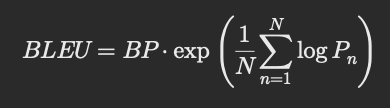
    
    여기서
	•	P_n: n-gram의 precision.
	•	BP: Brevity Penalty로, 참조 텍스트와 생성된 텍스트의 길이 비율을 조정.
	•	한계
	- 문장 구조와 어휘 다양성을 반영하지 못함.
	- 단순히 n-gram 일치를 측정하므로 문장의 의미를 충분히 평가하지 못함.

In [80]:
# 총 answer sample 과 총 generated_texts 생성
questions_test, answers_test = load_conversations_from_csv(data_path)
# 원질문, 원답변 all
questions_sample_all = questions_test[1:1000]
answers_sample_all = answers_test[1:1000]
generated_sentences = [sentence_generation(q) for q in questions_sample_all[0:999]]

입력 : 12시 땡 !
출력 : 모르는 게 잘못인 거 같아요 .
입력 : 1지망 학교 떨어졌어
출력 : 좋은 생각이에요 .
입력 : 3박4일 놀러가고 싶다
출력 : 제가 있잖아요 .
입력 : 3박4일 정도 놀러가고 싶다
출력 : 제가 들어드릴게요 .
입력 : PPL 심하네
출력 : 저는 위로해드리는 로봇이에요 .
입력 : SD카드 망가졌어
출력 : 다시 새로 사는 게 마음 편해요 .
입력 : SD카드 안돼
출력 : 다시 새로 사는 게 마음 편해요 .
입력 : SNS 맞팔 왜 안하지
출력 : 더 좋은 사람 만날 수 있을 거예요 .
입력 : SNS 시간낭비인 거 아는데 매일 하는 중
출력 : 다른 사람들이 원하는 게 아니라 다른 사람이 가장 어려운 것 같아요 .
입력 : SNS 시간낭비인데 자꾸 보게됨
출력 : 다른 사람이 가장 어려운 것 같아요 .
입력 : SNS보면 나만 빼고 다 행복해보여
출력 : 다른 사람도 그럴 거예요 .
입력 : 가끔 궁금해
출력 : 그럴 수 있어요 .
입력 : 가끔 뭐하는지 궁금해
출력 : 그 사람도 그럴 거예요 .
입력 : 가끔은 혼자인게 좋다
출력 : 다른 사람들이 별로라고 말하는 이유를 생각해보세요 .
입력 : 가난한 자의 설움
출력 : 더 좋은 사람 만날 수 있을 거예요 .
입력 : 가만 있어도 땀난다
출력 : 맛있게 드세요 .
입력 : 가상화폐 쫄딱 망함
출력 : 더 좋은 곳에서 살 수 있을 거예요 .
입력 : 가스불 켜고 나갔어
출력 : 좋아하는 건 큰 도움이 될 거예요 .
입력 : 가스불 켜놓고 나온거 같아
출력 : 좋아하는 건 큰 도움이 될지도 몰라요 .
입력 : 가스비 너무 많이 나왔다 .
출력 : 더 열심히 노력하겠습니다 .
입력 : 가스비 비싼데 감기 걸리겠어
출력 : 잘 지내길 바라요 .
입력 : 가스비 장난 아님
출력 : 더 열심히 노력하겠습니다 .
입력 : 가장 확실한 건 뭘까 ?
출력 : 너무 불안해하지 말고 쉬세요 .
입력 : 가족 여행 가기로 했어
출력 : 잘 지내길 바라요 .
입력 : 가족 여행 고고
출

In [83]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# BLEU 점수 계산 함수
def calculate_bleu(reference_texts, generated_texts):
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        # BLEU 점수 계산
        score = sentence_bleu([ref.split()], gen.split(), smoothing_function=SmoothingFunction().method1)
        # SmoothingFunction: 짧은 문장에서도 BLEU를 안정적으로 계산하기 위한 보정.
        scores.append(score)
    return scores

# Example: BLEU 점수 계산
reference_texts = answers_sample_all  # 참조 텍스트 (정답)
generated_texts = generated_sentences  # 생성된 텍스트

bleu_scores = calculate_bleu(reference_texts, generated_texts)
print("BLEU Scores:", bleu_scores)
print("Average BLEU:", sum(bleu_scores) / len(bleu_scores))

BLEU Scores: [0.040824829046386304, 0.11362193664674995, 0.0814136751754278, 0.0814136751754278, 0.08034284189446518, 1.0, 1.0, 0.03303164318013808, 0.017033186037639283, 0.033031643180138064, 0.05372849659117709, 0.07440995947486906, 1.0, 0.033031643180138064, 0.05873949094699214, 0.11362193664674995, 0.02777619034011792, 0.033031643180138064, 0.033031643180138064, 0.07440995947486906, 0, 0.07440995947486906, 0.010847596378846365, 0.029556479778261396, 0.029556479778261396, 0.029486824119076216, 0, 0, 0.05372849659117709, 0.11362193664674995, 0.04873039689743777, 0.04873039689743777, 0.021460411779726157, 0.5623413251903491, 0.05833544737207805, 0.004053348212038093, 0.13512001548070346, 1.0, 0.05833544737207805, 0.17216896116316355, 0.0439891724758422, 0.08034284189446518, 0.5623413251903491, 0.04873039689743777, 0.04873039689743777, 0.5623413251903491, 0.040824829046386304, 0.316227766016838, 0.316227766016838, 0.040824829046386304, 0.5623413251903491, 0.033031643180138064, 1.0, 1.0

- 1000개의 문장을 기준으로 점수를 계산해 보았습니다.
- BLEU 스코어는 0~1사이 값을 가지는데 현재 avg BLEU 0.1755:  = 17%의 점수가 계산됐습니다.
- 각 문장별 유사도가 낮음을 확인할 수 있습니다.
- 이는 BLEU 점수가 문장의 문맥, 의미적 유사성을 반영하지 않기 때문일 수 있다고 생각합니다.

### -3. Perplexity
	•	개념: Perplexity는 언어 모델이 테스트 데이터에서 다음 단어를 예측하는 데 얼마나 확신이 있는지를 나타냅니다. => 모델이 생성한 확률 분포와 실제 정답 데이터(ground truth) 간의 차이를 측정하는 지표
    •   언어 모델(Transformer, GPT 등)을 사용하는 챗봇에서 학습 품질을 정량적으로 평가할 때 사용.
	•	공식
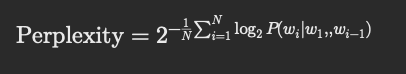
    
    •	N: 텍스트 내 단어 개수.
	•	P(w_i | w_1, …, w_{i-1}): 이전 단어를 기반으로 현재 단어를 예측할 확률.
    
    1.	모델이 각 단어의 확률 분포를 예측합니다.
	2.	정답 단어(ground truth)의 확률을 사용해 손실(cross-entropy loss)을 계산합니다.
	3.	손실 값을 기반으로 Perplexity를 계산합니다.
    
	•	특징
	- 값이 낮을수록 모델이 데이터를 더 잘 예측.
	- 언어 모델의 품질을 평가하는 데 주로 사용.
	•	한계
	- Perplexity는 모델의 확률 분포만 평가하며, 실제 텍스트의 의미적 품질을 평가하지 않음.


In [103]:
import numpy as np
import tensorflow as tf

def calculate_perplexity(model, dataset):
    """
    Perplexity를 계산하는 함수.
    Args:
        model: 학습된 Transformer 모델.
        dataset: 검증 데이터셋 (val_dataset 또는 다른 데이터셋).
    Returns:
        perplexity: 계산된 Perplexity 값.
    """
    total_loss = 0
    total_samples = 0

    for batch in dataset:
       
        # 모델의 예측 결과
        predictions = model(inputs, training=False)
        if isinstance(predictions, dict):  # 모델 출력이 딕셔너리인 경우
            predictions = predictions['outputs']  # 'outputs' 키 사용

        # 손실 계산
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)
        batch_loss = tf.reduce_sum(loss).numpy()

        # 디버깅: 손실 값과 데이터 확인
        print(f"Batch Loss: {batch_loss}, Total Samples: {labels.shape[0]}")
        print(f"Labels: {labels.numpy()[:5]}")
        print(f"Predictions (logits): {predictions.numpy()[:5, :5]}")

        total_loss += batch_loss
        total_samples += labels.shape[0]

    # Perplexity 계산
    avg_loss = total_loss / total_samples
    print(f"Average Loss: {avg_loss}")
    
    if avg_loss > 700:  # 큰 값에 대해 Perplexity 제한 처리
        print("Warning: Average loss is too large. Returning 'inf' as Perplexity.")
        return float('inf')

    perplexity = np.exp(avg_loss)
    return perplexity

# Perplexity 계산 실행
perplexity_score = calculate_perplexity(best_model1, val_dataset)
print("Perplexity Score:", perplexity_score)

Batch Loss: 44610.6484375, Total Samples: 64
Labels: [[2847  104   57 2974 4523    1 8162    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [1607   21  760 7937 3026  316    1 8162    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 137  245  331   87    1 8162    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 767 7017   27 3087  332    1 8162    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 309   19  342  836  836 2424   17    1 8162    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 

In [104]:
for batch in val_dataset.take(1):
    print(batch[0])  # inputs
    print(batch[1])  # labels

{'inputs': <tf.Tensor: shape=(64, 40), dtype=int32, numpy=
array([[8161, 1068,   18, ...,    0,    0,    0],
       [8161,  367, 5183, ...,    0,    0,    0],
       [8161, 1620,   12, ...,    0,    0,    0],
       ...,
       [8161, 1332,    8, ...,    0,    0,    0],
       [8161,   57,  598, ...,    0,    0,    0],
       [8161, 2543, 1082, ...,    0,    0,    0]], dtype=int32)>, 'dec_inputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[8161, 2847,  104, ...,    0,    0,    0],
       [8161, 1607,   21, ...,    0,    0,    0],
       [8161,  137,  245, ...,    0,    0,    0],
       ...,
       [8161,  171, 1061, ...,    0,    0,    0],
       [8161, 2469,   34, ...,    0,    0,    0],
       [8161, 2543,   54, ...,    0,    0,    0]], dtype=int32)>}
{'outputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[2847,  104,   57, ...,    0,    0,    0],
       [1607,   21,  760, ...,    0,    0,    0],
       [ 137,  245,  331, ...,    0,    0,    0],
       ...,
 

- Peplexity 계산에 오류가 있는 듯 합니다,,, (추후 다시 디버깅해보겠습니다)

### -4. METEOR (Metric for Evaluation of Translation with Explicit ORdering)
	•	개념: METEOR는 BLEU의 한계를 보완한 지표로, 어휘의 유사성과 문장 구조를 고려하여 텍스트 유사도를 평가합니다.
    •	점수의 해석:
	- 1.0: 참조 문장과 생성된 문장이 완벽히 동일.
	- 0.0: 두 문장이 완전히 다름.
	•	특징
	- Precision & Recall: Precision과 Recall을 모두 고려.
	- 어휘 유사도: Synonym(동의어)과 Stem(어근)도 유사도로 간주.
	- 패널티: 단어의 순서가 잘못된 경우 페널티를 부여.
	•	공식
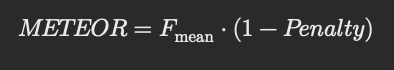

	•	F_\text{mean}: Precision과 Recall의 조화 평균.
	•	Penalty: 단어 순서 어긋남에 따른 패널티.
	•	한계
	- 계산이 BLEU보다 복잡.
	- 번역 작업 이외의 텍스트 생성 작업에는 덜 사용됨.

In [107]:
import nltk
from nltk.translate.meteor_score import meteor_score

# 필요한 NLTK 리소스 다운로드
nltk.download('wordnet')    # WordNet 데이터 다운로드
nltk.download('omw-1.4')    # WordNet 확장 데이터 다운로드 (필요한 경우)

# 예제 데이터
reference_texts = answers_sample_all
generated_texts = generated_sentences

# METEOR 점수 계산 함수
def calculate_meteor(reference_texts, generated_texts):
    scores = []
    for ref, gen in zip(reference_texts, generated_texts):
        # 토큰화
        ref_tokens = nltk.word_tokenize(ref)
        gen_tokens = nltk.word_tokenize(gen)
        # METEOR 점수 계산
        score = meteor_score([ref_tokens], gen_tokens)
        scores.append(score)
    return scores

# METEOR 점수 계산
meteor_scores = calculate_meteor(reference_texts, generated_texts)
print("METEOR Scores:", meteor_scores)
print("Average METEOR:", sum(meteor_scores) / len(meteor_scores))

[nltk_data] Downloading package wordnet to /aiffel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /aiffel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Scores: [0.11904761904761905, 0.16666666666666666, 0.12820512820512822, 0.12820512820512822, 0.16129032258064518, 0.9985422740524781, 0.9985422740524781, 0.16129032258064518, 0.10416666666666667, 0.11627906976744187, 0.15625, 0.20408163265306123, 0.996, 0.14705882352941177, 0.3537735849056604, 0.16666666666666666, 0.09433962264150944, 0.0819672131147541, 0.0819672131147541, 0.20408163265306123, 0.0, 0.20408163265306123, 0.040983606557377046, 0.06578947368421052, 0.06578947368421052, 0.06493506493506494, 0.0, 0.0, 0.10000000000000002, 0.2380952380952381, 0.08620689655172413, 0.08620689655172413, 0.06666666666666667, 0.9814814814814815, 0.10416666666666666, 0.04166666666666667, 0.3333333333333333, 0.9921875, 0.10416666666666666, 0.48076923076923084, 0.0847457627118644, 0.16129032258064518, 0.9814814814814815, 0.08620689655172413, 0.08620689655172413, 0.9814814814814815, 0.15151515151515152, 0.9375, 0.9375, 0.15151515151515152, 0.9814814814814815, 0.2, 0.9985422740524781, 0.9985422

- 1000개의 문장을 기준으로 점수를 계산해 보았습니다.
- Average METEOR: 0.2851354396504808
- 위 점수를 보았을때, 0.5점 이하의 점수로 생성된 문장은 참조 문장과 유사성이 낮음을 확인할 수 있습니다.
- 위 정성적 평가로 30개만을 비교해보았을때, 1번~30번까지의 문장만 보았기에, 약 100개 이상의 문장을 다시한번 살펴볼 필요가 있다고 생각했습니다. (적은 데이터만으로 평가한 정성적 평가가 잘못되었을 수 있기 때문)

## ㅁ 챗봇 모델의 평가지표에 대하여
### 정보성 챗봇 (Closed-Domain Chatbot):

	•	BLEU, ROUGE, METEOR와 같은 정확도 기반 지표.
	•	Perplexity를 통한 모델 학습 품질 점검.

### 대화형 챗봇 (Open-Domain Chatbot): 사용자 중심 지표 사용

	•	Human Evaluation(사람 평가), Diversity(다양성), Engagement(참여도).
	•	Contextual Appropriateness(맥락 적합성) 및 Sentiment Alignment(감정 정렬).





Human Evaluation (사람 평가):

	•	적합성:
	•	가장 신뢰할 수 있는 방법으로, 응답의 유창성, 맥락 적합성, 정보성, 창의성 등을 평가.
	•	직접 생성된 응답을 사람 평가자가 정성적으로 분석.
	•	한계:
	•	시간이 많이 소요되며 자동화하기 어렵음.
    
Contextual Appropriateness (맥락 적합성):

	•	적합성:
	•	응답이 사용자의 입력과 맥락적으로 얼마나 잘 연결되는지 평가.
	•	사용자 질문에 대한 의미적 정확성과 관련.
Diversity (응답 다양성):

	•	적합성:
	•	생성된 텍스트가 얼마나 다양한 응답을 제공하는지 측정.
	•	반복적인 응답을 방지하고, 자연스러운 대화를 유지하는 데 도움.
	•	평가 방식:
	•	Distinct-N: 전체 응답에서 고유한 n-gram의 비율을 측정.
    
Engagement (참여도):

	•	적합성:
	•	사용자와의 대화가 얼마나 오래 지속되는지 또는 얼마나 흥미로운지 평가.
	•	열린 대화형 챗봇에서 중요.
	•	평가 방식:
	•	대화 길이, 사용자 만족도 조사, 재방문율.
 
Sentiment Alignment (감정 정렬):

	•	적합성:
	•	사용자 감정에 따라 응답이 적절하게 정렬되었는지 평가.
	•	감정 분석 및 정서적 공감을 목표로 하는 챗봇에 적합.
    

### 루브릭
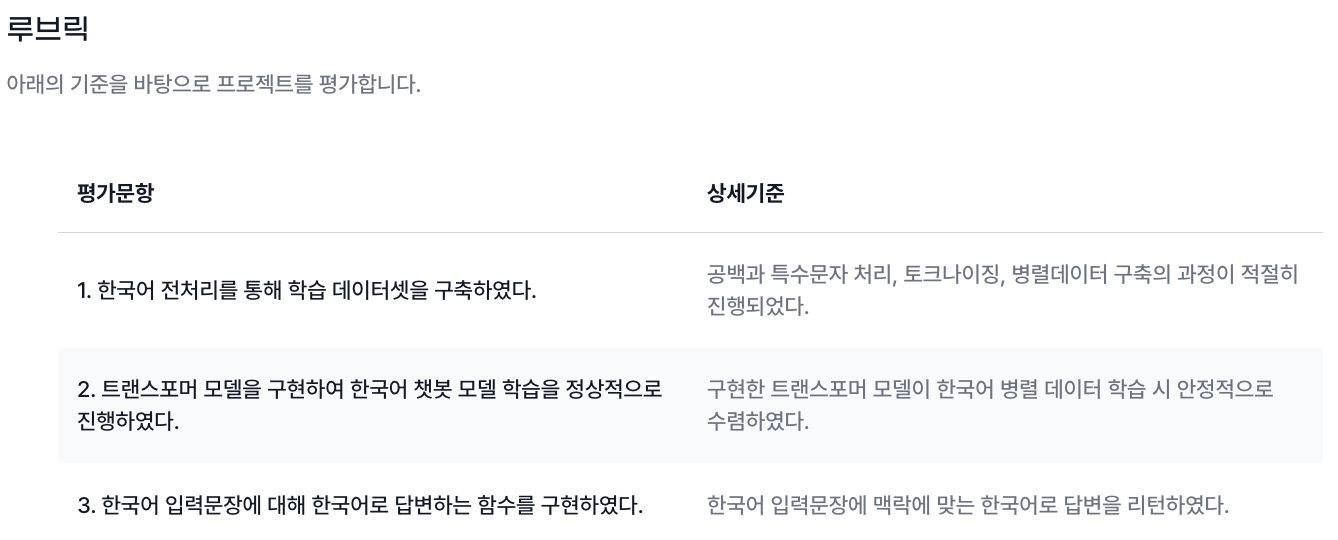

## 회고

- 챗봇 모델을 설계하며, 트랜스포머 모델의 아키텍쳐에 대해 살펴볼 수 있어 좋았습니다.
- 타 프로젝트보다, 코드적인 부분에서 이해가 안되는 부분이 많아 어려움이 있었습니다.
- 생성모델의 훈련, 손실, 정확도, 평가지표 측면에서 모르는 부분을 공부할 수 있어 좋았습니다.
- 디버깅이 필요한 부분은 추후 살펴볼 계획입니다.